In [1]:
import os
import tarfile
import urllib
import matplotlib.pyplot as plt
import sklearn
import numpy as np 
import scipy as scp
import pandas as pd
import matplotlib # plotting library 
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

<b>Load Data <b>

In [2]:
DATASET_PATH = os.path.join("datasets", "airbnb")
def load_airbnb_data(airbnb_path):
    csv_path = os.path.join(airbnb_path, "AB_NYC_2019.csv")
    return pd.read_csv(csv_path)
airbnb = load_airbnb_data(DATASET_PATH)

#drop problematic/ unhelpful data columns
airbnb=airbnb.drop(["name","id","host_id","host_name","last_review","reviews_per_month", "neighbourhood"], axis=1)

<b>Visualize Data Set<b>

In [3]:
airbnb.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000


In [4]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   latitude                        48895 non-null  float64
 2   longitude                       48895 non-null  float64
 3   room_type                       48895 non-null  object 
 4   price                           48895 non-null  int64  
 5   minimum_nights                  48895 non-null  int64  
 6   number_of_reviews               48895 non-null  int64  
 7   calculated_host_listings_count  48895 non-null  int64  
 8   availability_365                48895 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 3.4+ MB


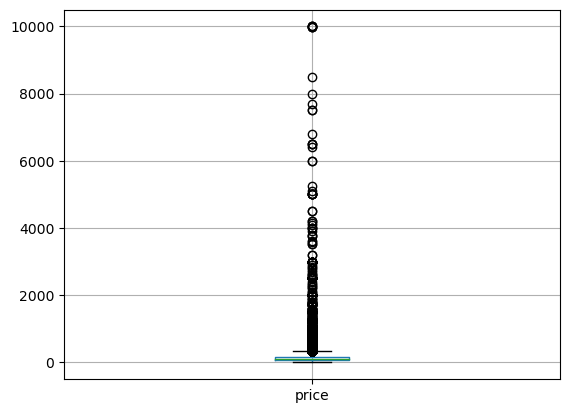

In [5]:
airbnb.boxplot(column='price')
plt.show()

Boxplot for price has many outliers. Thus, there is a substantial number of airbnb rental which dont follow the general trends of price as most other airbnbs in New York

<b> Features Related to Price <b>

/var/folders/md/k7zvqvcs0kx0tt50zhwxvmzr0000gn/T/ipykernel_3185/3541027993.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  neighbourhood_group_median = airbnb.groupby("neighbourhood_group").median()


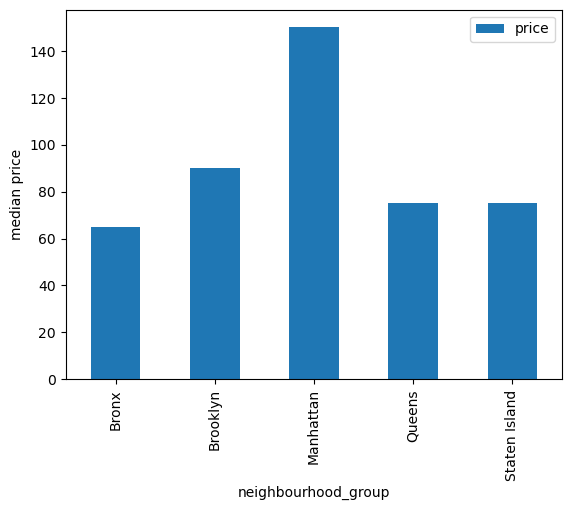

In [6]:
#median price of listing per neighbourhood_group
neighbourhood_group_median = airbnb.groupby("neighbourhood_group").median()

neighbourhood_group_median.plot.bar(y ="price", ylabel= "median price")
plt.show()

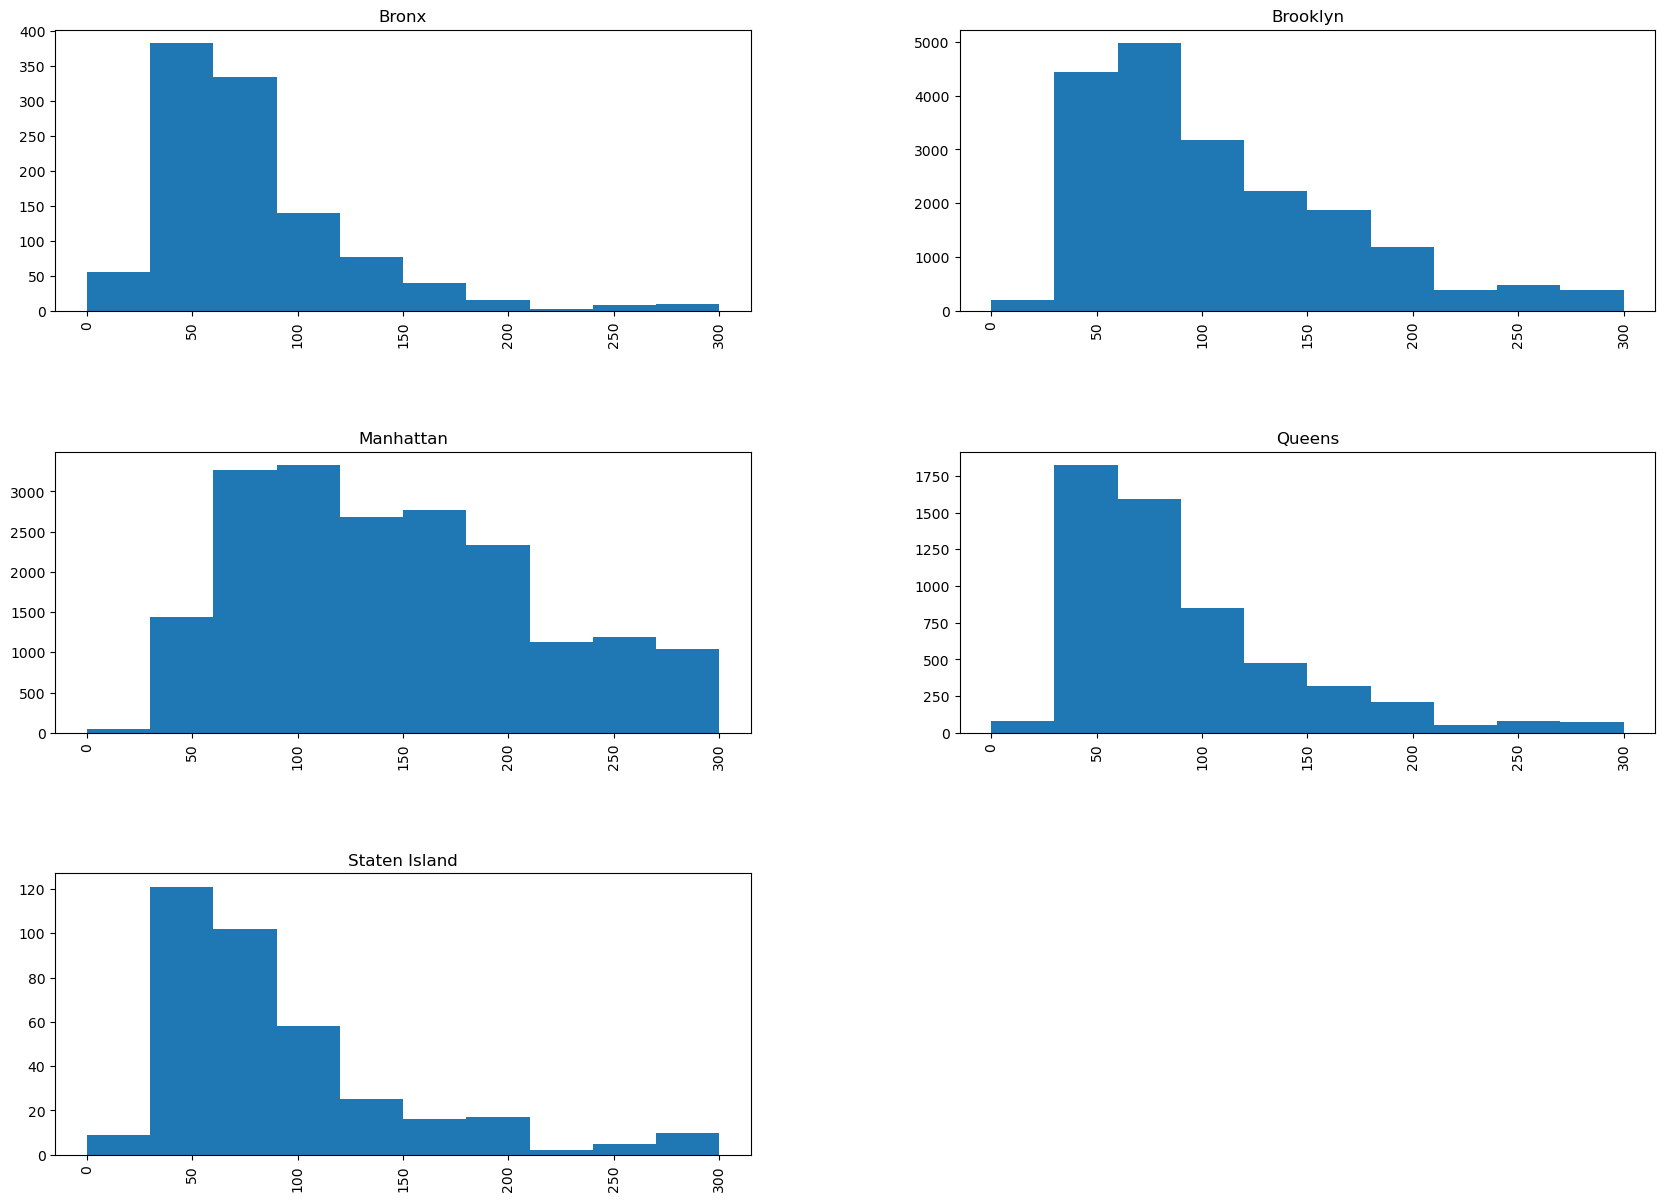

In [7]:
#histogram of price per neighbourhood
airbnb["price"].hist(by= airbnb["neighbourhood_group"],figsize=(20,15), range=[0,300])
plt.show()

/var/folders/md/k7zvqvcs0kx0tt50zhwxvmzr0000gn/T/ipykernel_3185/3748789908.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)


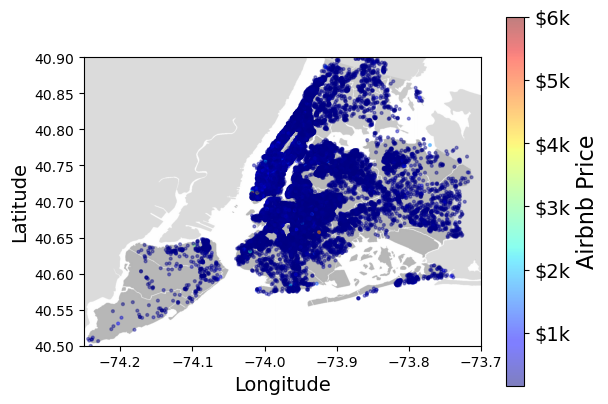

In [8]:
#mapping ny airbnbs and price

images_path = os.path.join('./', "images")
os.makedirs(images_path, exist_ok=True)
filename = "newyork.png"

import matplotlib.image as mpimg
ny_img=mpimg.imread(os.path.join(images_path, filename))
ax = airbnb.plot(kind="scatter", x="longitude", y="latitude", s=4,c="price", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,)
# overlay the newyork map on the plotted scatter plot
plt.imshow(ny_img, extent=[-74.25, -73.7, 40.5, 40.9], alpha=0.5,cmap=plt.get_cmap("jet"))
# setting up heatmap colors based on airbnb price feature
prices = airbnb["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cb = plt.colorbar()
cb.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cb.set_label('Airbnb Price', fontsize=16)
#save_fig("california_housing_prices_plot")
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

In [9]:
#median price of airbnb depending on type of rental
Manhattan_avail_median=airbnb.groupby("room_type").median()
Manhattan_avail_median.plot.bar(y ="price", ylabel= "median price", xlabel ="room type of airbnbs")

/var/folders/md/k7zvqvcs0kx0tt50zhwxvmzr0000gn/T/ipykernel_3185/1049084570.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Manhattan_avail_median=airbnb.groupby("room_type").median()


<Axes: xlabel='room type of airbnbs', ylabel='median price'>

In [10]:
corr_matrix=airbnb.corr()
corr_matrix["price"].sort_values(ascending=False)

/var/folders/md/k7zvqvcs0kx0tt50zhwxvmzr0000gn/T/ipykernel_3185/3969664534.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=airbnb.corr()


price                             1.000000
availability_365                  0.081829
calculated_host_listings_count    0.057472
minimum_nights                    0.042799
latitude                          0.033939
number_of_reviews                -0.047954
longitude                        -0.150019
Name: price, dtype: float64

In [11]:
attributes = ["price", "availability_365", "calculated_host_listings_count",
              "minimum_nights", "number_of_reviews"]
scatter_matrix(airbnb[attributes], figsize=(25,25))

array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='availability_365', ylabel='price'>,
        <Axes: xlabel='calculated_host_listings_count', ylabel='price'>,
        <Axes: xlabel='minimum_nights', ylabel='price'>,
        <Axes: xlabel='number_of_reviews', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='availability_365'>,
        <Axes: xlabel='availability_365', ylabel='availability_365'>,
        <Axes: xlabel='calculated_host_listings_count', ylabel='availability_365'>,
        <Axes: xlabel='minimum_nights', ylabel='availability_365'>,
        <Axes: xlabel='number_of_reviews', ylabel='availability_365'>],
       [<Axes: xlabel='price', ylabel='calculated_host_listings_count'>,
        <Axes: xlabel='availability_365', ylabel='calculated_host_listings_count'>,
        <Axes: xlabel='calculated_host_listings_count', ylabel='calculated_host_listings_count'>,
        <Axes: xlabel='minimum_nights', ylabel='calculated_host_listings_count'>,
        <Axe

<b> Prepare Data <b>

In [12]:
airbnb_target = airbnb['price'].copy()
airbnb_features=airbnb.drop("price", axis=1)

airbnb_cat=airbnb_features[["neighbourhood_group", "room_type"]].copy()
airbnb_num=airbnb_features.drop(["neighbourhood_group","room_type"], axis=1)

In [13]:
def distance_func(loc_a,loc_b):
    """
    Calculates the haversine distance between coordinates
    on the latitude and longitude grid. 
    Distance is in km.
    """
    lat1,lon1 = loc_a
    lat2,lon2 = loc_b
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [14]:
#class to add new columns which might be useful to model
class AugmentFeatures(BaseEstimator, TransformerMixin):
    '''
    '''
    def __init__(self): 
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        max_yearly_bookings = X[:, 5]/X[:,2]
        distance_JFK = distance_func((X[:,0],X[:,1]),(40.641766,-73.780968))
    
        return np.c_[X, max_yearly_bookings, distance_JFK]

In [15]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), #Imputes using median
        ('attribs_adder', AugmentFeatures()), 
        ('std_scaler', StandardScaler()),])


#Applies different transformations on numerical columns vs categorial columns
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, list(airbnb_num)),
        ("cat", OneHotEncoder(), list(airbnb_cat))])

airbnb_prepared = full_pipeline.fit_transform(airbnb_features)

In [16]:
data_target = airbnb['price']
train, test, target, target_test = train_test_split(airbnb_features, data_target, test_size=0.2)

train = full_pipeline.fit_transform(train)
test = full_pipeline.transform(test)

In [18]:
lin_reg=LinearRegression()
lin_reg.fit(train, target)

data = test
labels = target_test

#Uses predict to get the predicted target values
#print("Predictions:", lin_reg.predict(data)[:50])
#print("Actual labels:", list(labels)[:50])
test_preds = lin_reg.predict(test)
test_mse = mean_squared_error(target_test, test_preds)

train_preds = lin_reg.predict(train)
train_mse = mean_squared_error(target, train_preds)
print("Train MSE Value: ", train_mse,"\nTest MSE Value:", test_mse)

Train MSE Value:  54305.49351843054 
Test MSE Value: 41923.46182102096
